***Processing data for use with isotonic regression code from Dr. Riccardo Pellarin***

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import argparse

In [2]:
# Read in the csv file using pandas
data_dir = os.path.join(os.getcwd(), 'input_data')
df_raw = pd.read_csv(os.path.join(data_dir, 'TSTO_id_scores_data.csv'))
df_clean_raw = df_raw.fillna('')
df_clean_raw.head()

,Protein 1,Residue 1,Score 1,Protein 2,Residue 2,Score 2,Protein 3,Residue 3,Score 3
0,Rpn6,K141,37.7,Rpn6,K325,22.9,,,
1,Rpn6,K288,43.3,Rpn6,K304,51.2,,,
2,Rpn6,K288,32.8,Rpn6,K304,45.6,,,
3,Rpn6,K288,19.4,Rpn6,K304,48.4,,,
4,Rpn6,K288,13.9,Rpn6,K304,43.9,,,


In [3]:
# Filter out trifunctional crosslinks and bifunctional crosslinks from this dataframe

# Bifunctional crosslinks: where 'Protein 3' column is empty/null
df_bifunc = df_clean_raw[df_clean_raw['Protein 3'].isnull() | (df_clean_raw['Protein 3'] == '')].copy()
df_bifunc = df_bifunc.drop(columns=['Protein 3', 'Residue 3', 'Score 3'])

# Trifunctional crosslinks: where 'Protein 3' column has data
df_trifunc = df_clean_raw[df_clean_raw['Protein 3'].notnull() & (df_clean_raw['Protein 3'] != '')].copy()

print("Bifunctional crosslinks:")
print(df_bifunc.head())
print(f"\nNumber of bifunctional crosslinks: {len(df_bifunc)}")

print("\nTrifunctional crosslinks:")
print(df_trifunc.head())
print(f"Number of trifunctional crosslinks: {len(df_trifunc)}")

Bifunctional crosslinks:
  Protein 1 Residue 1  Score 1 Protein 2 Residue 2  Score 2
0      Rpn6      K141     37.7      Rpn6      K325     22.9
1      Rpn6      K288     43.3      Rpn6      K304     51.2
2      Rpn6      K288     32.8      Rpn6      K304     45.6
3      Rpn6      K288     19.4      Rpn6      K304     48.4
4      Rpn6      K288     13.9      Rpn6      K304     43.9

Number of bifunctional crosslinks: 3352

Trifunctional crosslinks:
    Protein 1 Residue 1  Score 1 Protein 2 Residue 2  Score 2 Protein 3  \
168      Rpn5      K294     12.6      Rpn5      K303     17.7      Rpn9   
169      Rpn5      K368     27.2      Rpn5      K376     17.4      Rpn9   
469     Rpn11      K152     14.9     Rpn11      K223     19.2      Rpn8   
619     Rpn11      K264     40.1      Rpn7      K126     15.4      Rpn7   
620     Rpn11      K264     40.2      Rpn7      K126     17.4      Rpn7   

     Residue 3 Score 3  
168       K132    25.6  
169  K321;K329    31.1  
469       K180    21.

In [4]:
# Filter out proteins from the base sub complex only, Rpt1 to Rpt6 and Rpn2, which means 
# Protein1, Protein2 (and Protein3 for trifunctional) should be in this list
base_sub_complex_proteins = ['Rpt1', 'Rpt2', 'Rpt3', 'Rpt4', 'Rpt5', 'Rpt6', 'Rpn2']
df_bifunc_base = df_bifunc[(df_bifunc['Protein 1'].isin(base_sub_complex_proteins)) & 
                            (df_bifunc['Protein 2'].isin(base_sub_complex_proteins))].copy()
df_trifunc_base = df_trifunc[(df_trifunc['Protein 1'].isin(base_sub_complex_proteins)) & 
                              (df_trifunc['Protein 2'].isin(base_sub_complex_proteins)) & 
                              (df_trifunc['Protein 3'].isin(base_sub_complex_proteins))].copy()
print(f"\nNumber of bifunctional crosslinks in base sub complex: {len(df_bifunc_base)}")
print(df_bifunc_base.head())
print(f"Number of trifunctional crosslinks in base sub complex: {len(df_trifunc_base)}")
print(df_trifunc_base.head())


Number of bifunctional crosslinks in base sub complex: 958
     Protein 1 Residue 1  Score 1 Protein 2 Residue 2  Score 2
1089      Rpt5      K120     16.8      Rpt5      K146     14.3
1090      Rpt5      K146     18.2      Rpt5      K276     36.6
1091      Rpt5      K146     17.5      Rpt5      K276     33.6
1092      Rpt5      K146     17.2      Rpt5      K276     32.5
1093      Rpt5      K146     14.9      Rpt5      K276     32.3
Number of trifunctional crosslinks in base sub complex: 116
     Protein 1 Residue 1  Score 1 Protein 2 Residue 2  Score 2 Protein 3  \
1065      Rpt5       K70     38.2      Rpt5       K74     25.9      Rpt5   
1066      Rpt5       K70     29.0      Rpt5       K74     24.6      Rpt5   
1067      Rpt5       K70     31.1      Rpt5       K74     18.9      Rpt5   
1068      Rpt5       K70     36.6      Rpt5       K74     27.1      Rpt5   
1069      Rpt5       K70     28.3      Rpt5       K74     25.5      Rpt5   

     Residue 3 Score 3  
1065       K81    16

=== BIFUNCTIONAL CROSSLINK PROCESSING ===
Original: 958 rows
After expansion: 1238 rows
After removing self-crosslinks: 1235 rows
Unique crosslinks: 163
Crosslinks with duplicates: 120
Final unique crosslinks: 163
Reduction: 1075 rows (86.8%)

Most duplicated: Rpt1-K181_Rpt1-K356 (51 occurrences)


/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_63132/1531978859.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=score_df, x='Score_Type', y='Score', ax=axes[1], palette='Set2')


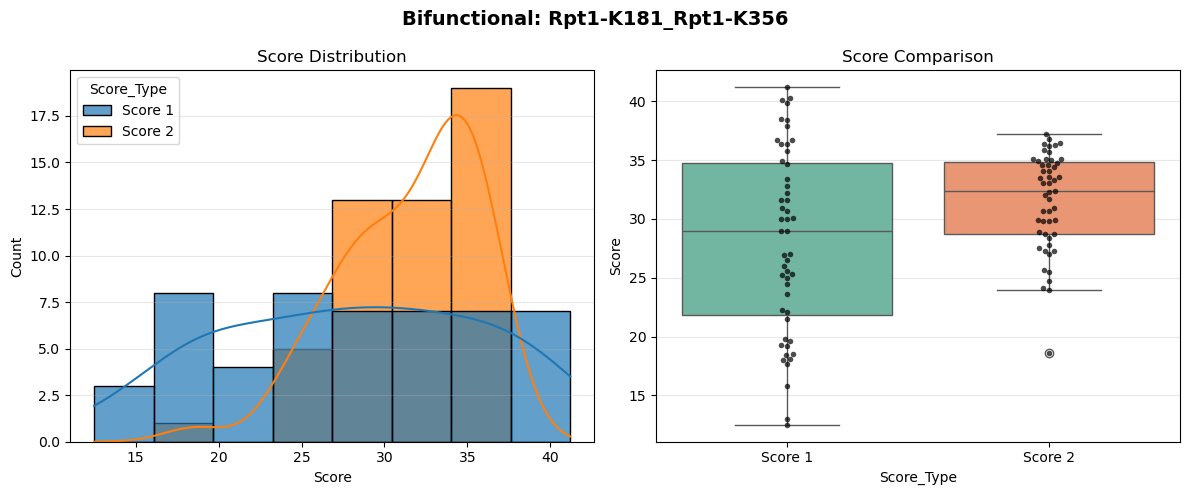


Final bifunctional dataset preview:
             Crosslink Protein 1 Residue 1 Protein 2 Residue 2    Score 1  \
0  Rpn2-K123_Rpn2-K196      Rpn2      K123      Rpn2      K196  25.734286   
1  Rpn2-K124_Rpn2-K196      Rpn2      K124      Rpn2      K196  25.833333   
2   Rpn2-K136_Rpt6-K15      Rpn2      K136      Rpt6       K15  39.472727   
3   Rpn2-K146_Rpt6-K15      Rpn2      K146      Rpt6       K15  29.695238   
4   Rpn2-K148_Rpt6-K15      Rpn2      K148      Rpt6       K15  34.300000   

     Score 2  Duplicate_Count  
0  15.254286               35  
1  15.373333               30  
2  43.336364               11  
3  39.785714               21  
4  39.750000                4  


In [ ]:
def expand_delimited_residues(df):
    """
    Expand rows where residues contain semicolons (;) or pipes (|) into all possible combinations.
    """
    expanded_rows = []
    
    for _, row in df.iterrows():
        # Split by both semicolon and pipe, then flatten
        def split_residue(residue_str):
            parts = str(residue_str).split(';')
            all_parts = []
            for part in parts:
                all_parts.extend(part.split('|'))
            return [p.strip() for p in all_parts if p.strip()]
        
        residue1_parts = split_residue(row['Residue 1'])
        residue2_parts = split_residue(row['Residue 2'])
        
        # Create all combinations
        for res1 in residue1_parts:
            for res2 in residue2_parts:
                new_row = row.copy()
                new_row['Residue 1'] = res1
                new_row['Residue 2'] = res2
                expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

def create_canonical_crosslink_id(row):
    """Create canonical crosslink ID treating A-B and B-A as identical."""
    pair1 = f"{row['Protein 1']}-{row['Residue 1']}"
    pair2 = f"{row['Protein 2']}-{row['Residue 2']}"
    return '_'.join(sorted([pair1, pair2]))

# BIFUNCTIONAL PROCESSING
print("=== BIFUNCTIONAL CROSSLINK PROCESSING ===")
print(f"Original: {len(df_bifunc_base)} rows")

# Step 1: Expand delimited residues
df_expanded = expand_delimited_residues(df_bifunc_base)
print(f"After expansion: {len(df_expanded)} rows")

# Step 2: Remove self-crosslinks
df_no_self = df_expanded[~((df_expanded['Protein 1'] == df_expanded['Protein 2']) & 
                          (df_expanded['Residue 1'] == df_expanded['Residue 2']))].copy()
print(f"After removing self-crosslinks: {len(df_no_self)} rows")

# Step 3: Create canonical IDs and remove duplicates
df_no_self['Crosslink'] = df_no_self.apply(create_canonical_crosslink_id, axis=1)
duplicate_counts = df_no_self['Crosslink'].value_counts()
print(f"Unique crosslinks: {len(duplicate_counts)}")
print(f"Crosslinks with duplicates: {(duplicate_counts > 1).sum()}")

# Step 4: Average duplicate scores
df_bifunc_base_unique = df_no_self.groupby('Crosslink').agg({
    'Protein 1': 'first', 'Residue 1': 'first', 'Protein 2': 'first', 'Residue 2': 'first',
    'Score 1': 'mean', 'Score 2': 'mean'
}).reset_index()
df_bifunc_base_unique['Duplicate_Count'] = df_no_self.groupby('Crosslink').size().values

print(f"Final unique crosslinks: {len(df_bifunc_base_unique)}")
print(f"Reduction: {len(df_expanded) - len(df_bifunc_base_unique)} rows ({((len(df_expanded) - len(df_bifunc_base_unique))/len(df_expanded)*100):.1f}%)")

# Visualization for most duplicated crosslink
if (duplicate_counts > 1).sum() > 0:
    most_duplicated = duplicate_counts.index[0]
    most_duplicated_data = df_no_self[df_no_self['Crosslink'] == most_duplicated]
    print(f"\nMost duplicated: {most_duplicated} ({len(most_duplicated_data)} occurrences)")
    
    # Prepare score data
    all_scores = []
    score_types = []
    for _, row in most_duplicated_data.iterrows():
        all_scores.extend([row['Score 1'], row['Score 2']])
        score_types.extend(['Score 1', 'Score 2'])
    
    score_df = pd.DataFrame({'Score': all_scores, 'Score_Type': score_types})
    
    # Create figure with larger size and fonts
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Bifunctional: {most_duplicated}', fontsize=24, fontweight='bold')
    
    # Score distribution (left plot)
    sns.histplot(data=score_df, x='Score', hue='Score_Type', kde=True, ax=axes[0], alpha=0.7)
    axes[0].set_title('Score Distribution', fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Score', fontsize=18)
    axes[0].set_ylabel('Count', fontsize=18)
    axes[0].tick_params(axis='both', labelsize=16)
    axes[0].legend(fontsize=16, title='Score Type', title_fontsize=16)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot comparison (right plot)
    sns.boxplot(data=score_df, x='Score_Type', y='Score', ax=axes[1], palette='Set2')
    sns.swarmplot(data=score_df, x='Score_Type', y='Score', ax=axes[1], color='black', size=6, alpha=0.7)
    axes[1].set_title('Score Comparison', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Score Type', fontsize=18)
    axes[1].set_ylabel('Score', fontsize=18)
    axes[1].tick_params(axis='both', labelsize=16)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save as PDF with high resolution
    pdf_filename = f'bifunctional_scores_{most_duplicated[:30].replace("/", "_")}.pdf'
    plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
    print(f"Saved figure to: {pdf_filename}")
    
    plt.show()

print(f"\nFinal bifunctional dataset preview:")
print(df_bifunc_base_unique.head())

=== TRIFUNCTIONAL CROSSLINK PROCESSING ===
Original: 116 rows
After expansion: 116 rows
After removing self-crosslinks: 116 rows
Unique crosslinks: 14
Final unique crosslinks: 14

Most duplicated: Rpt5-K70_Rpt5-K74_Rpt5-K81 (24 occurrences)


/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_63132/3365160276.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(fontsize=16, title='Score Type', title_fontsize=16)
/var/folders/hy/knb4qjqd78q038lgq2_49hrm0000gn/T/ipykernel_63132/3365160276.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=score_df_tri, x='Score_Type', y='Score', ax=axes[1], palette='Set2')


Saved figure to: trifunctional_scores_Rpt5-K70_Rpt5-K74_Rpt5-K81.pdf


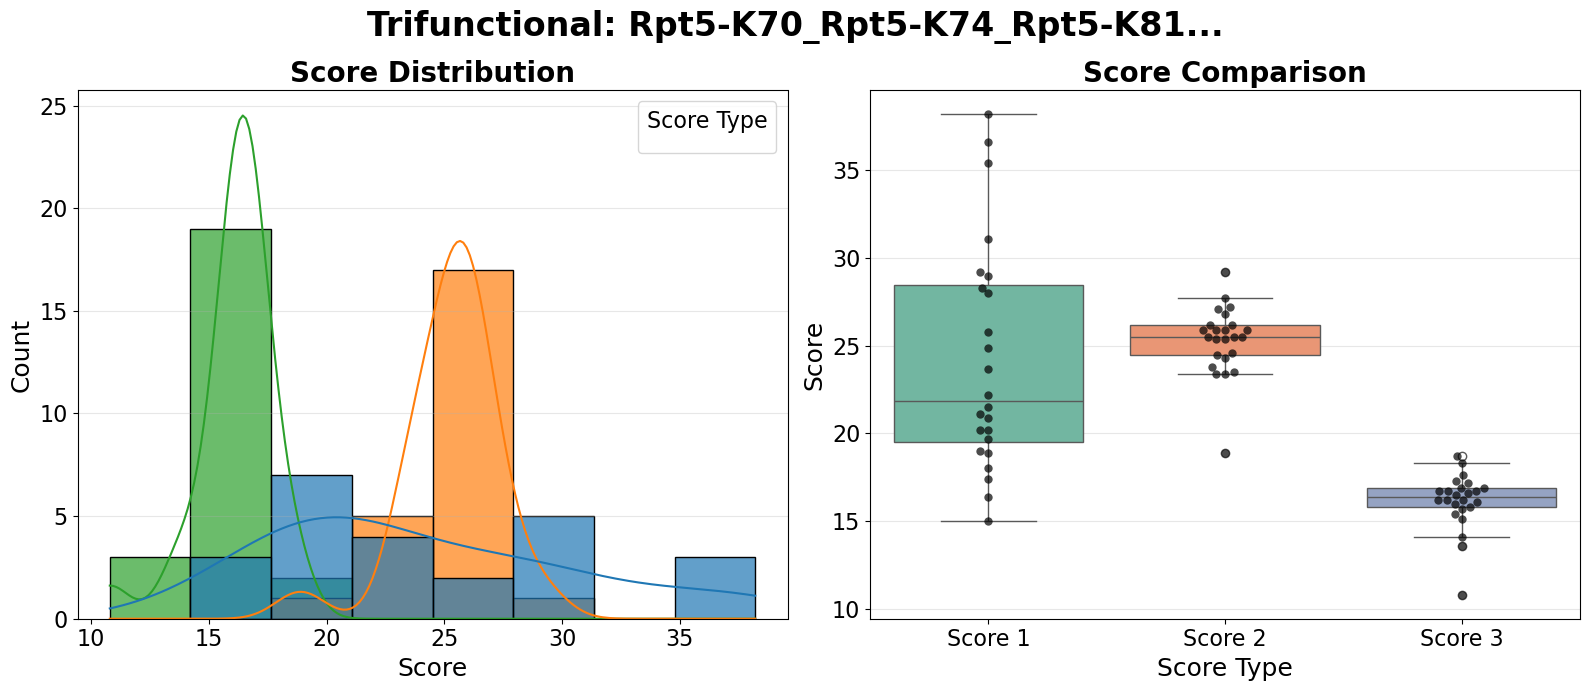


Final trifunctional dataset preview:
                       Crosslink Protein 1 Residue 1 Protein 2 Residue 2  \
0  Rpn2-K666_Rpn2-K807_Rpn2-K890      Rpn2      K666      Rpn2      K807   
1  Rpt1-K116_Rpt3-K238_Rpt4-K206      Rpt1      K116      Rpt3      K238   
2  Rpt1-K422_Rpt2-K293_Rpt2-K350      Rpt1      K422      Rpt2      K293   
3   Rpt1-K57_Rpt2-K178_Rpt6-K287      Rpt1       K57      Rpt2      K178   
4   Rpt2-K258_Rpt4-K72_Rpt6-K222      Rpt2      K258      Rpt4       K72   

  Protein 3 Residue 3    Score 1    Score 2    Score 3  Duplicate_Count  
0      Rpn2      K890  26.100000  33.700000  49.500000                1  
1      Rpt4      K206  34.666667  41.811111  43.016667               18  
2      Rpt2      K350  33.528571  29.814286  31.128571                7  
3      Rpt6      K287  33.650000  32.275000  50.200000                4  
4      Rpt6      K222  44.260000  37.120000  46.320000               15  


In [8]:
def expand_delimited_residues_trifunctional(df):
    """
    Expand trifunctional crosslinks with semicolons (;) or pipes (|) into all combinations.
    """
    expanded_rows = []
    
    for _, row in df.iterrows():
        def split_residue(residue_str):
            parts = str(residue_str).split(';')
            all_parts = []
            for part in parts:
                all_parts.extend(part.split('|'))
            return [p.strip() for p in all_parts if p.strip()]
        
        residue1_parts = split_residue(row['Residue 1'])
        residue2_parts = split_residue(row['Residue 2'])
        residue3_parts = split_residue(row['Residue 3'])
        
        for res1 in residue1_parts:
            for res2 in residue2_parts:
                for res3 in residue3_parts:
                    new_row = row.copy()
                    new_row['Residue 1'] = res1
                    new_row['Residue 2'] = res2
                    new_row['Residue 3'] = res3
                    expanded_rows.append(new_row)
    
    return pd.DataFrame(expanded_rows)

def create_canonical_trifunctional_crosslink_id(row):
    """Create canonical trifunctional crosslink ID."""
    pairs = [f"{row['Protein 1']}-{row['Residue 1']}", 
             f"{row['Protein 2']}-{row['Residue 2']}", 
             f"{row['Protein 3']}-{row['Residue 3']}"]
    return '_'.join(sorted(pairs))

# TRIFUNCTIONAL PROCESSING
if len(df_trifunc_base) == 0:
    print("=== NO TRIFUNCTIONAL CROSSLINKS ===")
else:
    print("=== TRIFUNCTIONAL CROSSLINK PROCESSING ===")
    print(f"Original: {len(df_trifunc_base)} rows")
    
    # Step 1: Expand delimited residues
    df_expanded_tri = expand_delimited_residues_trifunctional(df_trifunc_base)
    print(f"After expansion: {len(df_expanded_tri)} rows")
    
    # Step 2: Remove self-crosslinks (any two pairs identical)
    df_no_self_tri = df_expanded_tri[~(
        ((df_expanded_tri['Protein 1'] == df_expanded_tri['Protein 2']) & 
         (df_expanded_tri['Residue 1'] == df_expanded_tri['Residue 2'])) |
        ((df_expanded_tri['Protein 1'] == df_expanded_tri['Protein 3']) & 
         (df_expanded_tri['Residue 1'] == df_expanded_tri['Residue 3'])) |
        ((df_expanded_tri['Protein 2'] == df_expanded_tri['Protein 3']) & 
         (df_expanded_tri['Residue 2'] == df_expanded_tri['Residue 3']))
    )].copy()
    print(f"After removing self-crosslinks: {len(df_no_self_tri)} rows")
    
    # Step 3: Create canonical IDs and remove duplicates
    df_no_self_tri['Crosslink'] = df_no_self_tri.apply(create_canonical_trifunctional_crosslink_id, axis=1)
    duplicate_counts_tri = df_no_self_tri['Crosslink'].value_counts()
    print(f"Unique crosslinks: {len(duplicate_counts_tri)}")
    #print(f"Crosslinks with duplicates: {(duplicate_counts_tri > 1).sum()}")
    
    # Step 4: Average duplicate scores
    df_trifunc_base_unique = df_no_self_tri.groupby('Crosslink').agg({
        'Protein 1': 'first', 'Residue 1': 'first', 'Protein 2': 'first', 'Residue 2': 'first',
        'Protein 3': 'first', 'Residue 3': 'first', 'Score 1': 'mean', 'Score 2': 'mean', 'Score 3': 'mean'
    }).reset_index()
    df_trifunc_base_unique['Duplicate_Count'] = df_no_self_tri.groupby('Crosslink').size().values
    
    print(f"Final unique crosslinks: {len(df_trifunc_base_unique)}")
    # Write to file, with columns protein 1, residue 1, protein 2, residue 2, protein 3, residue 3 
    # leave out all other columns while writing to file 
    df_trifunc_base_unique.to_csv('tri.csv', columns=['Protein 1', 'Residue 1', 'Protein 2', 'Residue 2', 'Protein 3', 'Residue 3'], index=False)
    
    #print(f"Reduction: {len(df_expanded_tri) - len(df_trifunc_base_unique)} rows ({((len(df_expanded_tri) - len(df_trifunc_base_unique))/len(df_expanded_tri)*100):.1f}%)")
    
# Visualization for most duplicated crosslink
if (duplicate_counts_tri > 1).sum() > 0:
    most_duplicated_tri = duplicate_counts_tri.index[0]
    most_duplicated_data_tri = df_no_self_tri[df_no_self_tri['Crosslink'] == most_duplicated_tri]
    print(f"\nMost duplicated: {most_duplicated_tri} ({len(most_duplicated_data_tri)} occurrences)")
    
    # Prepare score data
    all_scores_tri = []
    score_types_tri = []
    for _, row in most_duplicated_data_tri.iterrows():
        all_scores_tri.extend([row['Score 1'], row['Score 2'], row['Score 3']])
        score_types_tri.extend(['Score 1', 'Score 2', 'Score 3'])
    
    score_df_tri = pd.DataFrame({'Score': all_scores_tri, 'Score_Type': score_types_tri})
    
    # Create figure with larger size and fonts
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    fig.suptitle(f'Trifunctional: {most_duplicated_tri[:50]}...', fontsize=24, fontweight='bold')
    
    # Score distribution (left plot)
    sns.histplot(data=score_df_tri, x='Score', hue='Score_Type', kde=True, ax=axes[0], alpha=0.7)
    axes[0].set_title('Score Distribution', fontsize=20, fontweight='bold')
    axes[0].set_xlabel('Score', fontsize=18)
    axes[0].set_ylabel('Count', fontsize=18)
    axes[0].tick_params(axis='both', labelsize=16)
    axes[0].legend(fontsize=16, title='Score Type', title_fontsize=16)
    axes[0].grid(axis='y', alpha=0.3)
    
    # Box plot comparison (right plot)
    sns.boxplot(data=score_df_tri, x='Score_Type', y='Score', ax=axes[1], palette='Set2')
    sns.swarmplot(data=score_df_tri, x='Score_Type', y='Score', ax=axes[1], color='black', size=6, alpha=0.7)
    axes[1].set_title('Score Comparison', fontsize=20, fontweight='bold')
    axes[1].set_xlabel('Score Type', fontsize=18)
    axes[1].set_ylabel('Score', fontsize=18)
    axes[1].tick_params(axis='both', labelsize=16)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    # Save as PDF with high resolution
    pdf_filename = f'trifunctional_scores_{most_duplicated_tri[:30].replace("/", "_")}.pdf'
    plt.savefig(pdf_filename, format='pdf', dpi=300, bbox_inches='tight')
    print(f"Saved figure to: {pdf_filename}")
    
    plt.show()

print(f"\nFinal trifunctional dataset preview:")
print(df_trifunc_base_unique.head())

## Score Combination Strategy for Isotonic Regression

### Scores Between 0 and 1

**normalizing scores to a 0-1 scale** makes scores from different experiments or search engines comparable and more intuitive to interpret within the probabilistic framework.

### The Best Strategy for Combining Multiple Scores

For crosslinks with multiple scores (Score 1, Score 2, and Score 3 for trifunctional), we need to combine them into a single confidence measure.

**Take the Minimum (Conservative Approach)**

- **Bifunctional crosslinks**: `Combined_Score = min(Score 1, Score 2)`
- **Trifunctional crosslinks**: `Combined_Score = min(Score 1, Score 2, Score 3)`

**Why minimum over average?** A crosslink is only as strong as its weakest link. If you have an excellent score for one peptide (e.g., 90) but poor evidence for another (e.g., 10), the average (50) suggests mediocre but acceptable confidence. In reality, the poor evidence makes the entire identification questionable. Taking the minimum correctly flags this as low-confidence, preventing false positives.

### Step-by-Step Procedure

1. **Combine Scores**: Create a single score using the minimum strategy
2. **Collect All Combined Scores**: Gather all combined scores across the dataset  
3. **Normalize to 0-1 Scale**: Apply min-max normalization using the global min/max
4. **Use Final Score**: Feed the normalized score to the isotonic regression model